# Preliminaries
First install a critical dependency for our code

In [1]:
!pip install keras==2.2.4 # critical dependency, 

     |████████████████████████████████| 317kB 4.3MB/s 
  Found existing installation: Keras 2.3.0
    Uninstalling Keras-2.3.0:
      Successfully uninstalled Keras-2.3.0


Write requirements to file, anytime you run it, in case you have to go back and recover dependencies.

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [2]:
!pip freeze > kaggle_image_requirements.txt

In [3]:
# Import neural network libraries
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer

# Initialize tensorflow/keras session
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


# Read and Preprocess Enron dataset
Read Enron dataset and get a sense for the data by printing sample messages to screen

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
filepath = "../input/enron-email-dataset/emails.csv"

# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath)

print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
print(emails.head())

Successfully loaded 517401 rows and 2 columns!
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [5]:
# take a closer look at the first email
print(emails.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


Separate headers from the message bodies

In [6]:
import email

def extract_messages(df):
    messages = []
    for item in df["message"]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        messages.append(message_body)
    print("Successfully retrieved message body from e-mails!")
    return messages

bodies = extract_messages(emails)

Successfully retrieved message body from e-mails!


In [7]:
# extract random 10000 enron email bodies for building dataset
import random
bodies_df = pd.DataFrame(random.sample(bodies, 10000))

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 300)

bodies_df.head() # you could do print(bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

,0
0,"---------------------- Forwarded by Christi L Nicolay/HOU/ECT on 07/03/2001 \n10:59 AM ---------------------------\nFrom: Alan Comnes/ENRON@enronXgate on 07/03/2001 10:37 AM\nTo: Mark Palmer/Corp/Enron@ENRON, Christi L Nicolay/HOU/ECT@ECT, Sarah \nNovosel/Corp/Enron@ENRON, Susan J Mara/NA/Enron@..."
1,"Mr. Greg Whalley\nPresident & COO\nEnron Corp.\n\nDear Mr. Whalley:\n\nPowerful new forces are transforming the North American gas and power\nindustry, bringing considerable volatility and uncertainty to investment\nand strategy. Questions relating to prices, security, geopolitics, the\nglobal e..."
2,"Joe,\n\nFYI. Please plan on attending. We should schedule a meeting with\nmark and the rest of the weather team.\n\nVince\n\n---------------------- Forwarded by Vince J Kaminski/HOU/ECT on 11/06/2000 \n10:54 AM ---------------------------\n\n\n""Francis X. Diebold"" <fdiebold@sas.upenn.edu> on 11/..."
3,"---------------------- Forwarded by Darron C Giron/HOU/ECT on 11/21/2000 \n08:35 AM ---------------------------\n\n\nDawn C Kenne\n11/10/2000 04:08 PM\nTo: Michelle Bythewood <rbwood@ix.netcom.com>, ""Bythewood, Richard"" \n<rbythewood@txi.com>, ""derek campbell"" <derek.campbell@paslode.com>, \nPMD..."
4,"I am not sure if this made it earlier or not\n\n -----Original Message-----\nFrom: \tGeaccone, Tracy \nSent:\tThursday, October 18, 2001 11:07 AM\nTo:\tMcCarty, Danny; Cordes, Bill; Stanley, Brian; FOWLER, PEGGY; Garrison, John L; Hughes, James A.; Umanoff, Adam\nCc:\tAnderson, Michael; Sommers..."


The following (commented out) code is arguably the more "pythonic" way of achieving the extraction of bodies from messages. It is only 2 lines long and achieves the same result. However, we feel the code above is more transparent with regards to how the processing is carried out, and as such leave this here for the python experts if they prefer.

In [8]:
#messages = emails["message"].apply(email.message_from_string)
#bodies_df = messages.apply(lambda x: x.get_payload()).sample(10000)

# Read and Preprocess Fraudulent "419" Email Corpus

In [9]:
filepath = "../input/fraudulent-email-corpus/fradulent_emails.txt"
with open(filepath, 'r',encoding="latin1") as file:
    data = file.read()
    
# split on a code word appearing close to the beginning of each email
fraud_emails = data.split("From r")

print("Successfully loaded {} spam emails!".format(len(fraud_emails)))

Successfully loaded 3978 spam emails!


In [10]:
fraud_bodies = extract_messages(pd.DataFrame(fraud_emails,columns=["message"],dtype=str))
fraud_bodies_df = pd.DataFrame(fraud_bodies[1:])

fraud_bodies_df.head() # you could do print(fraud_bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

Successfully retrieved message body from e-mails!


,0
0,"FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-27-587908.\nE-MAIL: (james_ngola2002@maktoob.com).\n\nURGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\n\nDEAR FRIEND,\n\nI AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY G..."
1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom officer and work as Assistant controller of the Customs and Excise department Of the Federal Ministry of Internal Affairs stationed at the Murtala Mohammed International Airport, Ikeja, Lagos-Nigeria.\n\nAfter the sudden death of the former Head of s..."
2,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
3,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
4,"Dear sir, \n \nIt is with a heart full of hope that I write to seek your help in respect of the context below. I am Mrs. Maryam Abacha the former first lady of the former Military Head of State of Nigeria General Sani Abacha whose sudden death occurred on 8th of June 1998 as a result of cardiac ..."


# Define Tokenization, Stop-word and Punctuation Removal Functions
Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters

In [11]:
Nsamp =1000 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

**Tokenization**

In [12]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        tokens = str(row).split(" ")[:maxtokens]
    return tokens

**Use regular expressions to remove unnecessary characters**

Next, we define a function to remove punctuation marks and other nonword characters (using regular expressions) from the emails with the help of the ubiquitous python regex library. In the same step, we truncate all tokens to hyperparameter maxtokenlen defined above.

In [13]:
import re

def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

**Stop-word removal**

Let’s define a function to remove stopwords - words that occur so frequently in language that they offer no useful information for classification. This includes words such as “the” and “are”, and the popular library NLTK provides a heavily-used list that will employ.

In [14]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Putting It All Together To Assemble Dataset

Now, putting all the preprocessing steps together we assemble our dataset...

In [15]:
import random

# Convert everything to lower-case, truncate to maxtokens and truncate each token to maxtokenlen
EnronEmails = bodies_df.iloc[:,0].apply(tokenize)
EnronEmails = EnronEmails.apply(stop_word_removal)
EnronEmails = EnronEmails.apply(reg_expressions)
EnronEmails = EnronEmails.sample(Nsamp)

SpamEmails = fraud_bodies_df.iloc[:,0].apply(tokenize)
SpamEmails = SpamEmails.apply(stop_word_removal)
SpamEmails = SpamEmails.apply(reg_expressions)
SpamEmails = SpamEmails.sample(Nsamp)

raw_data = pd.concat([SpamEmails,EnronEmails], axis=0).values

In [16]:
print("Shape of combined data is:")
print(raw_data.shape)
print("Data represented as numpy array is:")
print(raw_data)

# corresponding labels
Categories = ['spam','notspam']
header = ([1]*Nsamp)
header.extend(([0]*Nsamp))

Shape of combined data is:
(2000,)
Data represented as numpy array is:
[list(['emailmessagemessage', 'object', 'xfdacdfbe', 'emailmessagemessage', 'object', 'xfdacdfb'])
 list(['fromb', 'mrse', 'erry', 'heryatitelefax', 'nba', '', '', '', 'emaila', 'erryheryatiecomunited', 'kingdomei', 'access', 'amount', 'excess', 'use', 'mc', 'i', 'seek', 'partnership', 'accommodating', 'mee', 'you', 'rewarded', '', 'total', 'sum', 'partnershipe', 'can', 'partner', 'thisfi', 'mrse', 'erry', 'heryati', 'an', 'indonesian', 'birthc', 'i', 'personal', 'secretary', 'mre', 'alexei', 'pichugin', 'former', 'security', 'chief', 'yukos', 'oil', 'company', 'russia', 'russian', 'most', 'largest', 'oil', 'companyc', 'unfortunately', 'charged', 'fake', 'charges', 'sentenced', '', 'years', 'imprisonment', 'murder', 'commit', 'still', 'facing', 'new', 'charges', 'russiae', 'until', 'recently', 'i', 'living', 'moscowc', 'relocate', 'go', 'exile', 'london', 'i', 'currently', 'recovering', 'injuries', 'inflicted', 'rai

In [17]:
# function for shuffling data
def unison_shuffle(a, b):
    p = np.random.permutation(len(b))
    data = a[p]
    header = np.asarray(b)[p]
    return data, header

# function for converting data into the right format, due to the difference in required format from sklearn models
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data,header):
    converted_data, labels = [], []
    for i in range(raw_data.shape[0]):
        # combine list of tokens representing each email into single string
        out = ' '.join(raw_data[i])
        converted_data.append(out)
        labels.append(header[i])
        #print(i)
    converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]
    return converted_data, np.array(labels)

raw_data, header = unison_shuffle(raw_data, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*raw_data.shape[0])
# 70% of data for training
train_x, train_y = convert_data(raw_data[:idx],header[:idx])
# remaining 30% for testing
test_x, test_y = convert_data(raw_data[idx:],header[idx:])

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
1400
[['dear sirfmadamci got contact email directory decided contact assistancee i son johnson savimbi rebel leader angola short dead th februaryc c opposing angolan armyeplease take a look at this web page for it says allehttpaffnewsebbcecoeukfhifenglishfworldfafricafnewsidffestmbefore death father deposited m sixteen million dollars security company europe valuablese all legal documents deposit mother father gave safe keepinge after death father i family fled south africa currently livinge and trying fly europe difficult us get visas africae so want help us make claims fund m europe family beneficiary transfer money account account choice i family get visas fly country share moneyemy family agreed give c would emillion dollars']
 ['fromathe desk of the accountant of iconshore investment and finance bankee attention a request for business relationshipedear sirfmadamc i mredonald gagec credit officer iconshore investme

# Build, Train and Evaluate ELMo Model
Create a custom tf hub ELMO embedding layer

In [18]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024 # initialize output dimension of ELMo embedding
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape): # function for building ELMo embedding
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name)) # download pretrained ELMo model
        
        # extract trainable parameters, which are only a small subset of the total - this is a constraint of
        # the tf hub module as shared by the authors - see https://tfhub.dev/google/elmo/2
        # the trainable parameters are 4 scalar weights on the sum of the outputs of ELMo layers 
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None): # specify function for calling embedding
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_output_shape(self, input_shape): # specify output shape
        return (input_shape[0], self.dimensions)

We now use the custom TF hub ELMo embedding layer within a higher-level function to define the overall model. 
More specifically, we put a dense trainable layer of output dimension 256 on top of the ELMo embedding. 

In [19]:
# Function to build overall model
def build_model():
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense = layers.Dense(256, activation='relu')(embedding)
    pred = layers.Dense(1, activation='sigmoid')(dense) # we could use sigmoid activation as well, but we choose softmax
                                                        # to enable us use sparse_categorical_crossentropy and 
                                                        # sparse_categorical_accuracy below
    
    model = Model(inputs=[input_text], outputs=pred)
    # use sparse_categorical_crossentropy and sparse_categorical_accuracy do avoid having to
    # one-hot encode the labels
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [20]:
# Build and fit
model = build_model()
history = model.fit(train_x, 
          train_y,
          validation_data=(test_x, test_y),
          epochs=5,
          batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,661
Trainable params: 262,661
Non-trainable params: 0
_________________________________________________________________
Train on 1400 samples, validate on 600 samples
Epoch 1/5
1400/1400 [==============================] - 47s 34ms/step - loss: 0.5124 - acc: 0.8250 - val_loss: 0.4171 - val_acc: 0.8533
Epoch 2/5
1400/1400 [==============================] - 40s 28ms/step - loss: 0.1914 - 

**Save trained model**

In [21]:
model.save('ELMoModel.h5')


**Visualize Convergence**

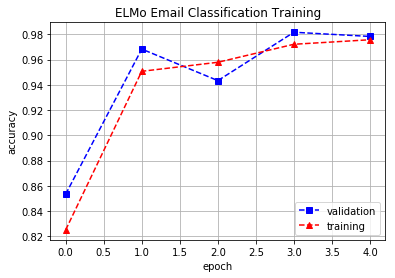

In [22]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)

fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ELMo Email Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()
# Save figures
fig.savefig('ELMoConvergence.eps', format='eps')
fig.savefig('ELMoConvergence.pdf', format='pdf')
fig.savefig('ELMoConvergence.png', format='png')
fig.savefig('ELMoConvergence.svg', format='svg')

**Make figures downloadable to local system in interactive mode**

In [23]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='ELMoConvergence.svg')